In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host="localhost",
                             username="root",
                             password="root",
                             database="ecommerce_db"
                            )
cur = db.cursor()

# 1. List all unique cities where customers are located.

In [19]:
query = """ select distinct customer_city from customers """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [4]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data = cur.fetchall()
print("total orders in 2017 are:",data)

total orders in 2017 are: [(45101,)]


# 3. Find the total sales per category.

In [6]:
query = """ select a1.product_category, round(sum(a3.payment_value),2) as total from products a1 join order_items a2 
on a1.product_id = a2.product_id
join payments a3 on a2.order_id = a3.order_id
group by product_category """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["category","sales"])
df

,category,sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# 4. Calculate the percentage of orders that were paid in installments.

In [9]:
query = """ select (sum(case when payment_installments>=1 then 1 else 0 end))/count(*)*100 from payments """
cur.execute(query)
data = cur.fetchall()
'percentage of order that paid in installments',data[0][0]

('percentage of order that paid in installments', Decimal('99.9981'))

# 5. Count the number of customers from each state.

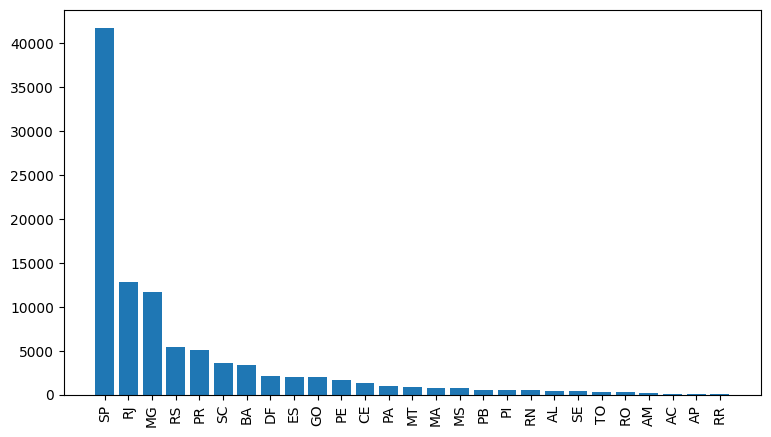

In [16]:
query =  """ select customer_state, count(customer_id) from customers group by customer_state """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["state","count"])
df = df.sort_values(by="count", ascending=False)
plt.figure(figsize=(9,5))
plt.bar(df["state"],df["count"])
plt.xticks(rotation = 90)
plt.show()

# Calculate the number of orders per month in 2018

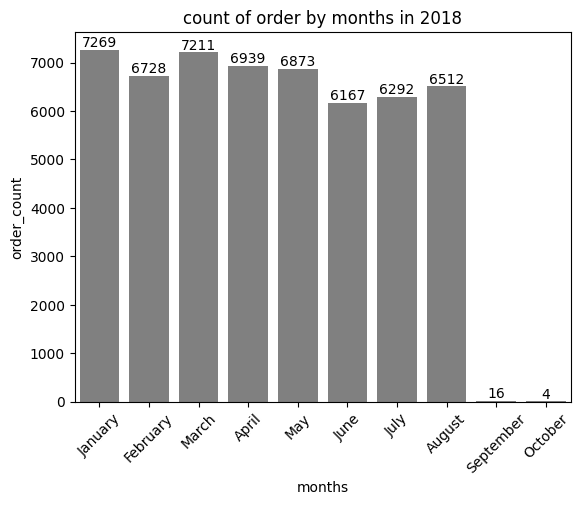

In [30]:
query = """ select monthname(order_purchase_timestamp) as months, count(order_id) as count
from orders
where year(order_purchase_timestamp) = 2018
group by months """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["months","order_count"])
o = ["January","February","March","April","May","June","July","August","September","October"]
ax = sns.barplot(x=df["months"],y=df["order_count"],data=df,order=o,color = "grey")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("count of order by months in 2018")
plt.show()

# Find the average number of products per order, grouped by customer city.

In [36]:
query = """ with count_order as(select o1.order_id, o1.customer_id, count(o2.order_item_id) as oc
from orders o1 join order_items o2 on o1.order_id = o2.order_id
group by o1.order_id, o1.customer_id)
select c.customer_city, round(avg(oc),2) as avg from customers c join count_order c1
on c.customer_id = c1.customer_id
group by customer_city 
order by avg desc """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["city", "avg"])
df.head()

,city,avg
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00


# Calculate the percentage of total revenue contributed by each product category.

In [40]:
query = """ select p.product_category, 
round((sum(p1.payment_value)/(select sum(payment_value) from payments))*100,2) as pct
from products p join order_items o
on p.product_id = o.product_id
join payments p1 
on p1.order_id = o.order_id
group by product_category
order by pct desc """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["product_category","payment_pct"])
df.head()

,product_category,payment_pct
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93


# Identify the correlation between product price and the number of times a product has been purchased.

In [7]:
query = """ select p.product_category, count(o.product_id) as product_count, 
round(avg(o.price),2) as price from products p join order_items o
on p.product_id = o.product_id
group by product_category
order by price desc"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["product_category","count","price"])
arr1 = df["count"]
arr2 = df["price"]
a = np.corrcoef([arr1,arr2])
print("correlation between order count and price is:",a[0][1])

correlation between order count and price is: -0.10631514167157557


# Calculate the total revenue generated by each seller, and rank them by revenue

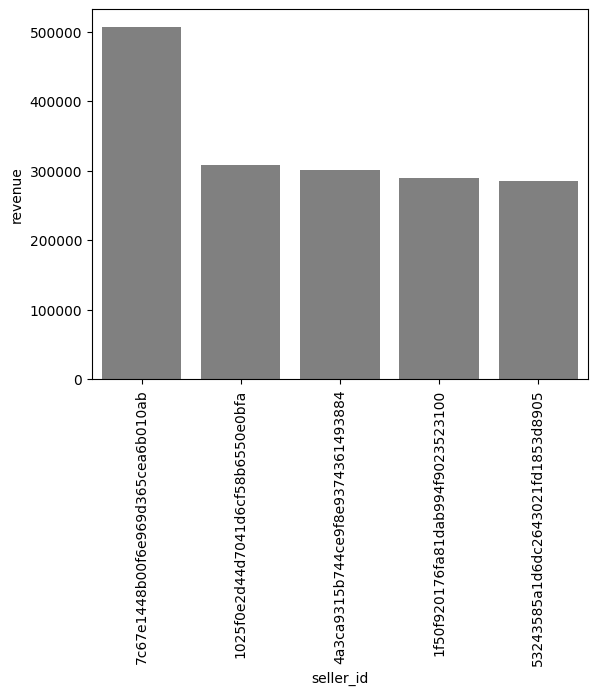

In [10]:
query = """ select *, dense_rank() over(order by revenue desc) as rnk from
(select o.seller_id, round(sum(p.payment_value),2) as revenue from order_items o
join payments p on p.order_id = o.order_id
group by seller_id) as a """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id","revenue","rank"])
df = df.head()
sns.barplot(x="seller_id",y="revenue",data=df, color="grey")
plt.xticks(rotation=90)
plt.show()

# Calculate the moving average of order values for each customer over their order history

In [22]:
query = """ select customer_id,order_purchase_timestamp,revenue,
round(avg(revenue) over(partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row),2) as mov_avg from 
(select o.customer_id,o.order_purchase_timestamp,p.payment_value as revenue from orders o join payments p 
on o.order_id = p.order_id) as a """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["customer_id","order_purchase_timestamp","value","mov_avg"])
df.head(20)

,customer_id,order_purchase_timestamp,value,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.80
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.40
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.59
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.23
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.71


# Calculate the cumulative sales per month for each year

In [24]:
query = """ select years,months,sales, sum(sales) over(order by years,months) as cumulative_sales from
(select year(o.order_purchase_timestamp) as years,
month(o.order_purchase_timestamp) as months,
round(sum(p.payment_value),2) as sales from orders o join payments p
on o.order_id = p.order_id
group by years,months
order by years,months) as a """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["year","month","sales","cumulative_sales"])
df

,year,month,sales,cumulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Calculate the year-over-year growth rate of total sales

In [26]:
query = """ with cte1 as (select year(o.order_purchase_timestamp) as years,
round(sum(p.payment_value),2) as cur_year_sales from orders o join payments p
on o.order_id = p.order_id
group by years
order by years),
cte2 as (select *, lag(cur_year_sales,1) over(order by years) as ls_year_sales from cte1)
select years,cur_year_sales,ls_year_sales, 
round(((cur_year_sales-ls_year_sales)/ls_year_sales) *100,2) as pct_diff from cte2 """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["year","cur_year_sales","ls_year_sales","pct_diff"])
df

,year,cur_year_sales,ls_year_sales,pct_diff
0,2016,59362.34,NaN,NaN
1,2017,7249746.73,59362.34,12112.7
2,2018,8699763.05,7249746.73,20.0


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [27]:
query = """ with a as (select c.customer_id, min(o.order_purchase_timestamp) as first_order from orders o join customers c
on o.customer_id = c.customer_id
group by customer_id)
select a.customer_id, count(distinct order_purchase_timestamp)
from a join orders o
on a.customer_id = o.customer_id
and o.order_purchase_timestamp > first_order
and o.order_purchase_timestamp < date_add(first_order, interval 6 month)  
group by customer_id """
cur.execute(query)
data = cur.fetchall()
data

[]

In [ ]:
# since non of our customers are repeated thats why value is null.

#  Identify the top 3 customers who spent the most money in each year.

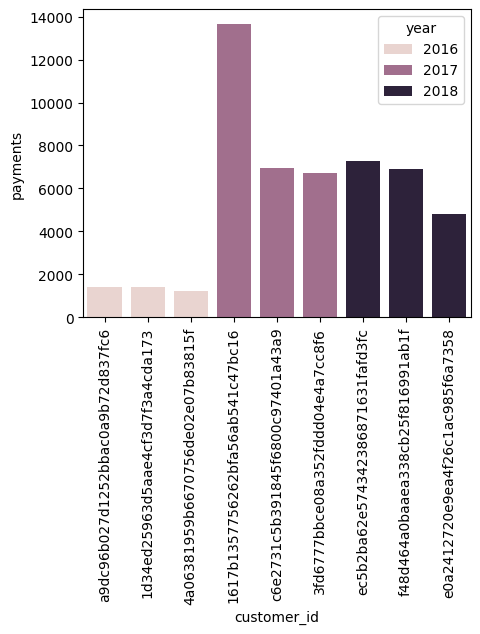

In [3]:
query = """ select years, customer_id, payments, d_rank from
(select year(o.order_purchase_timestamp) as years, o.customer_id, round(sum(p.payment_value),2) as payments,
dense_rank() over(partition by year(o.order_purchase_timestamp) order by sum(p.payment_value) desc) as d_rank from orders o join payments p 
on o.order_id = p.order_id
group by years, customer_id) as a
where d_rank <=3 """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["year","customer_id","payments","ranks"])
plt.figure(figsize=(5,4))
sns.barplot(x="customer_id",y="payments",data=df,hue="year")
plt.xticks(rotation=90)
plt.savefig("top 3 customers.jpg")
plt.show()